In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from src.Transformer.DecoderOnly import PointSimplexDecoderOnlyTransformer
from src.Datasets.SyntheticDataset import SimplePeriodicDataset
from src.Transformer.DistanceMetrics import euclidean
from torch.utils.data import DataLoader, random_split

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SimplePeriodicDataset(len_timeseries=512, seq_len=48, shift=1)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size

train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

# === Model ===
model = PointSimplexDecoderOnlyTransformer(
    d_in=dataset[0][0].shape[-1] + dataset[0][1].shape[-1],
    d_out=dataset[0][0].shape[-1],
    emb_size=128,
    ffn_n_hidden=128,
    num_layers=3,
    norm_first=True,
    distance_metric=euclidean,
    conv_out_dim=64,
    kernel_size=3,
    n_heads=1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

for epoch in range(60):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for X_src, fX_src, _, fX_tgt in train_loader:
        X_src, fX_src, fX_tgt = X_src.to(device), fX_src.to(device), fX_tgt.to(device)

        # Create causal mask
        mask = torch.tril(torch.ones((dataset[0][0].shape[1], dataset[0][0].shape[1]), device=device)).unsqueeze(0).repeat(X_src.size(0), 1, 1)

        preds = model(X_src, fX_src, mask=mask)
        target = fX_tgt[..., 0].unsqueeze(-1)

        loss = criterion(preds, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_src, fX_src, _, fX_tgt in val_loader:
            X_src, fX_src, fX_tgt = X_src.to(device), fX_src.to(device), fX_tgt.to(device)

            mask = torch.tril(torch.ones((dataset[0][0].shape[1], dataset[0][0].shape[1]), device=device)).unsqueeze(0).repeat(X_src.size(0), 1, 1)
            preds = model(X_src, fX_src, mask)
            target = fX_tgt[..., 0].unsqueeze(-1)

            loss = criterion(preds, target)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/60 | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")


Epoch 1/60 | Train Loss: 5276.5955 | Val Loss: 4643.7065
Epoch 2/60 | Train Loss: 4114.3552 | Val Loss: 3453.5847
Epoch 3/60 | Train Loss: 2972.8619 | Val Loss: 2184.2855
Epoch 4/60 | Train Loss: 1601.0364 | Val Loss: 878.1057
Epoch 5/60 | Train Loss: 702.4230 | Val Loss: 916.2538
Epoch 6/60 | Train Loss: 838.2206 | Val Loss: 824.7970
Epoch 7/60 | Train Loss: 648.4679 | Val Loss: 716.4225
Epoch 8/60 | Train Loss: 671.5187 | Val Loss: 689.4006
Epoch 9/60 | Train Loss: 617.5999 | Val Loss: 703.9431
Epoch 10/60 | Train Loss: 622.3258 | Val Loss: 695.5426
Epoch 11/60 | Train Loss: 618.2094 | Val Loss: 677.7494
Epoch 12/60 | Train Loss: 614.2784 | Val Loss: 676.4381
Epoch 13/60 | Train Loss: 607.9575 | Val Loss: 679.3040
Epoch 14/60 | Train Loss: 602.9798 | Val Loss: 676.0580
Epoch 15/60 | Train Loss: 605.5518 | Val Loss: 665.8891
Epoch 16/60 | Train Loss: 594.1986 | Val Loss: 657.2514
Epoch 17/60 | Train Loss: 590.6040 | Val Loss: 646.2621
Epoch 18/60 | Train Loss: 572.7854 | Val Loss: 622

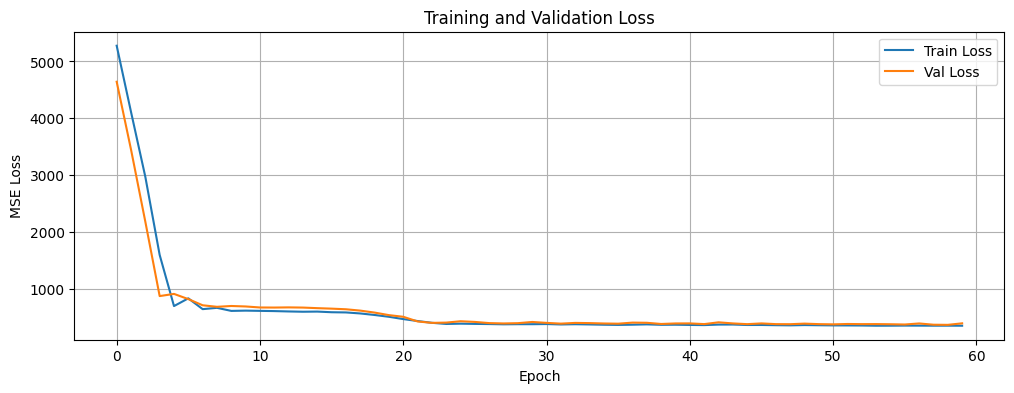

In [5]:
# === Plot Loss ===
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()

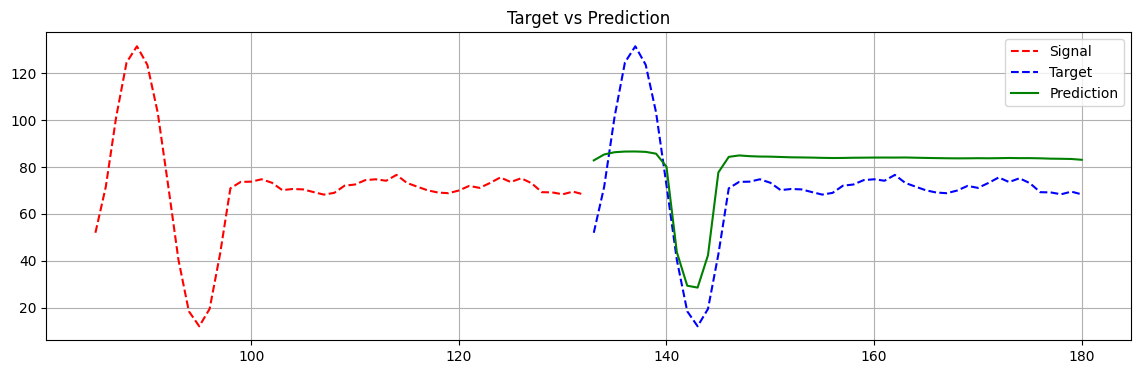

In [6]:
# === Visualize Prediction ===
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Signal')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

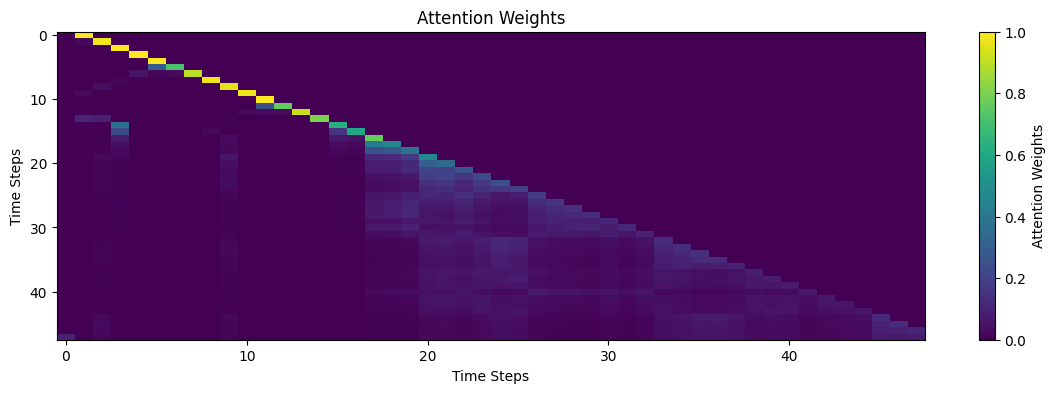

In [7]:
# visualize attention weights in a plot underneath the time series
plt.figure(figsize=(14, 4))
plt.imshow(model.transformer_blocks[0].attention.attention_weight.squeeze(0).cpu(), cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weights')
plt.title("Attention Weights")
plt.xlabel("Time Steps")
plt.ylabel("Time Steps")
plt.show()


Text(0, 0.5, 'Time Steps')

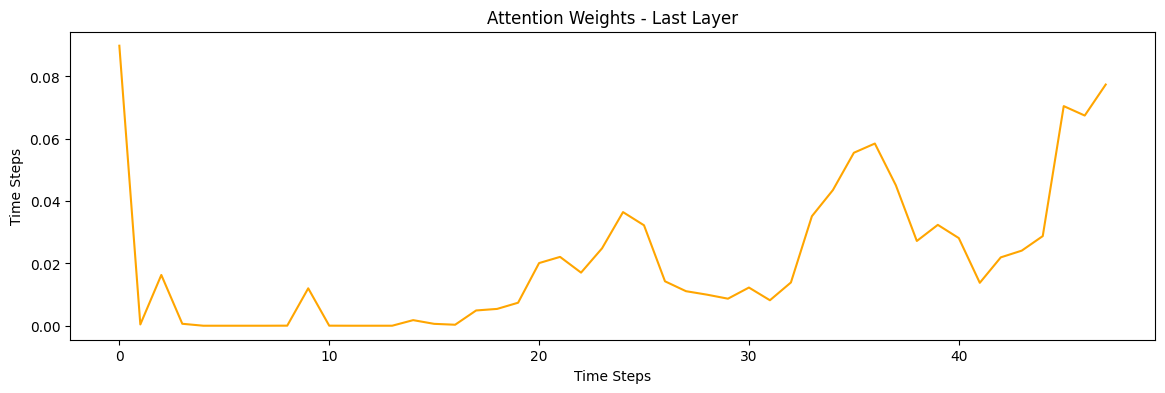

In [8]:
# Plot only last attention weights
plt.figure(figsize=(14, 4))
plt.plot(model.transformer_blocks[0].attention.attention_weight.squeeze(0).cpu()[-1, :], label='Attention Weights', color='orange')
plt.title("Attention Weights - Last Layer")
plt.xlabel("Time Steps")
plt.ylabel("Time Steps")
